# Text Gen - Wine Reviews



### Tutorials I referenced: https://www.kaggle.com/mariapushkareva/wine-reviews-spacy-bert
### https://www.kaggle.com/kshitijmohan/wine-recommendation-system-based-on-bert

### My goal is to demo what I learned so start with purpose related ead meaning leanr from data to build - feature generate. Then topic modelling, word clouds, lemmitization, LSTM, LDA, 


In [57]:
#!pip freeze > /home/ec2-user/SageMaker/requirements_wine_tg.txt

In [5]:
#install packages: I like having the list available in the Jupyter notebook
!pip install wordcloud
!pip install squarify
!pip install tqdm
!pip install bert-for-tf2
!pip install sentencepiece
!pip install nltk
!pip install tensorflow
!pip install bokeh

     |████████████████████████████████| 366 kB 5.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 41 kB 277 kB/s eta 0:00:011
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-py3-none-any.whl size=30537 sha256=d39764233cd83d06abda0fb6a21bd27cee9b21b7244409b00beca68334814c85
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3e/b5/79/5dd9ad3a9e12dc7466306b573587f9b1ae871b1cea0d35ddd1
  Created wheel for py-params: filename=py_params-0.9.7-py3-none-any.whl size=7302 sha256=d8b9b9e9a5a6f5b3281da9f96b9b3b9288f470bfda04c79a686199daf94819fb
  Stored in directory: /home/ec2-user/.cache/pip/

In [6]:
# importing libraries
import os
import math
import datetime

from tqdm import tqdm

#bread and butter
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

#Bert
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

palette = sns.color_palette("colorblind")
 
# Use palplot and pass in the variable:
sns.palplot(palette)

sns.set(style='whitegrid', palette='colorblind')

# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 12

RANDOM_SEED = 43

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

%matplotlib inline
import matplotlib.pyplot as plt

import re
import matplotlib.image as image
import matplotlib.colors
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify as sq
from colorama import Fore, Back, Style

import nltk
nltk.download('stopwords')

import bokeh
bokeh.__version__

# Our numerical workhorses
import numpy as np
import pandas as pd

# Import Bokeh modules for interactive plotting
from bokeh.plotting import figure, output_file, show

# Display graphics in this notebook
bokeh.io.output_notebook()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading BokehJS ...

In [7]:
# Load data set
df = pd.read_csv('https://raw.githubusercontent.com/lju-lazarevic/wine/master/data/winemag-data-130k-v3.csv') 
df.head(3)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [8]:
df.shape

(119988, 14)

### Data Cleaning

In [9]:
# Since I am planning to use the description, drop any rows where description is null
df[pd.notnull(df.description)]  

df.shape # no duplicates, alright

(119988, 14)

In [10]:
# Missing values total and percent of column total. This should give me an idea how I will deal with nans.
# One of goals is to use charts to discover patterns in data.
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

missing_data  = pd.concat([total, percent], axis=1, keys=['Total Number', 'Percent of Total'])

# region 2 is not filled the most, no need to drop these though, I can create an unknown region.
# Percent of total tells me if it is worth to dive and correct manually which I am planning to do for some.

In [11]:
#Mini function to sort and return in red 
#ref pandas doc: https://pandas.pydata.org/docs/user_guide/style.html?highlight=color_negative_red
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for positive
    strings, black otherwise.
    """
    color = 'red' if val > 0 else 'black'
    return 'color: %s' % color

In [12]:
missing_data.style.applymap(color_negative_red)

,Total Number,Percent of Total
region_2,73219,61.021936
designation,34545,28.790379
taster_twitter_handle,29446,24.540787
taster_name,24917,20.766243
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
country,59,0.049172
variety,1,0.000833
winery,0,0.000000


### This is not bad at all. I knew the data set would be in a good shape however there still are a few things that can be done. First I see that the taster_twitter_handle has more nans then taster_name which tells me some of the reviewers do not have a twitter account. This is no reason to remove that row. 
- Populate nulls values of taster_name with "unknown reviewer"
- Populate nans of taster_twitter_handle by using taster_name. Order should allow this to populate correctly.
- My goal is to drop min number of values. So lets impute.

In [66]:
# pd.set_option('display.max_rows', df.shape[0]+1) # change pandas defaults to inspect the entire set.
# pd.reset_option('display.max_rows')

# Sometime it is noce to see more information about the data set 
# but defaults in Jupyter only show a smaller subset. Below code will update the defaults max to one more. 
# I also included how to reset it back  for when you are done. Alternatively you can return the specific 
# number of rows by using the head or tail() functions. [.tail(100)]

In [13]:
df.sort_values(by= 'taster_name').head(7)
# I dont need taster_twitter_handle, it is repeatition of the taster name and less complete then that one.
# Also for now dropping region 2, mostly nan and populated ones are mostly duplicates of region 1. 
# Perhaps later I can impute and see if I can increase accuracy. 

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
88026,93187,US,"Initially tight and closed on the nose, displa...",Reserve,89,75.0,Michigan,Old Mission Peninsula,NaN,Alexander Peartree,NaN,2 Lads 2012 Reserve Cabernet Franc (Old Missio...,Cabernet Franc,2 Lads
83018,87674,US,Crushed red and black berries meet sweet notes...,NaN,88,39.0,Virginia,Virginia,NaN,Alexander Peartree,NaN,Vint Hill 2012 Petit Verdot (Virginia),Petit Verdot,Vint Hill
68051,71258,US,"Waxy crayon, petrol and steely lemon aromas ma...",Riven Rock Vineyard,84,34.0,Texas,NaN,NaN,Alexander Peartree,NaN,Bending Branch 2014 Riven Rock Vineyard Viognier,Viognier,Bending Branch
77478,81595,US,"Ripe on the nose, with aromas of fruit cocktai...",Braganini Reserve,86,15.0,Michigan,Michigan,NaN,Alexander Peartree,NaN,St. Julian 2013 Braganini Reserve Riesling (Mi...,Riesling,St. Julian
77477,81594,US,Ripe peach and citrus blossom pervade over a d...,Braganini Reserve Mountain Road,86,20.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Braganini Reserve Mountain Roa...,Riesling,St. Julian
9922,9962,US,While the nose shows sweet aromas of cherry bu...,Reserve,87,40.0,Virginia,Virginia,NaN,Alexander Peartree,NaN,Winery at La Grange 2012 Reserve Cabernet Fran...,Cabernet Franc,Winery at La Grange
83027,87683,US,"A cocktail of freshly muddled raspberry, red c...",Gilbert's Vineyard,88,26.0,Virginia,Monticello,NaN,Alexander Peartree,NaN,Lovingston 2013 Gilbert's Vineyard Pinotage (M...,Pinotage,Lovingston


In [14]:
#drop taster_twitter_handle and region_2
df.drop(columns=['taster_twitter_handle', 'region_2'],inplace=True)

In [15]:
#update empty tasters as unknow taster
df['taster_name'].fillna('Unknown Taster', inplace=True)

In [16]:
df.sort_values(by= 'taster_name').tail(4)

,id,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
108081,116055,US,"This blend of nearly equal parts Mourvèdre, Gr...",Boar's Camp Kick Ranch,88,55.0,California,Sonoma County,Virginie Boone,Sanglier Cellars 2013 Boar's Camp Kick Ranch R...,Rhône-style Red Blend,Sanglier Cellars
82712,87346,US,Fully revealing in brioche and preserved lemon...,Reserve,91,56.0,California,Carneros,Virginie Boone,Cakebread 2013 Reserve Chardonnay (Carneros),Chardonnay,Cakebread
108084,116058,US,The addition of 10% Cabernet Sauvignon and 4% ...,NaN,88,38.0,California,Napa Valley,Virginie Boone,Silenus 2013 Merlot (Napa Valley),Merlot,Silenus
108565,116608,US,"Peppery and high-toned, this wine offers a res...",NaN,92,65.0,California,Napa Valley,Virginie Boone,ZD 2012 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,ZD


In [17]:
# Check missing data, again
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

missing_data  = pd.concat([total, percent], axis=1, keys=['Total Number', 'Percent of Total'])
missing_data.style.applymap(color_negative_red)

,Total Number,Percent of Total
designation,34545,28.790379
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
country,59,0.049172
variety,1,0.000833
winery,0,0.000000
title,0,0.000000
taster_name,0,0.000000
points,0,0.000000


### Now the largest issues are designation and region. Also since there is now only one region lets change region_1 to region. But first sort out the nan in variety and country

In [18]:
# By luck I checked variety NaN, I see that I already imputed taster_name as unknown tatster, this is also missing the designation. 
df[df['variety'].isna()]

,id,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
82317,86909,Chile,"A chalky, dusty mouthfeel nicely balances this...",NaN,88,17.0,Maipo Valley,NaN,Unknown Taster,Carmen 1999 (Maipo Valley),NaN,Carmen


In [19]:
df[df['country'].isna()]

# Not only Country but also province and Region are NaN.

,id,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
913,913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,Mike DeSimone,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
3124,3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,Roger Voss,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
4229,4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,Mike DeSimone,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9469,9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,Susan Kostrzewa,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9710,9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,Jeff Jenssen,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
11099,11150,NaN,"A blend of 85% Melnik, 10% Grenache Noir and 5...",NaN,89,20.0,NaN,NaN,Jeff Jenssen,Orbelus 2013 Melnik,Melnik,Orbelus
11297,11348,NaN,"Light and fruity, this is a wine that has some...",Partager,82,NaN,NaN,NaN,Roger Voss,Barton & Guestier NV Partager White,White Blend,Barton & Guestier
13939,14030,NaN,"This Furmint, grown in marl soils, has aromas ...",Márga,88,25.0,NaN,NaN,Jeff Jenssen,St. Donat 2013 Márga White,White Blend,St. Donat
15871,16000,NaN,"Jumpy, jammy aromas of foxy black fruits are s...",Valle de los Manantiales Vineyard,86,40.0,NaN,NaN,Michael Schachner,Familia Deicas 2015 Valle de los Manantiales V...,Tannat,Familia Deicas
16617,16749,NaN,Winemaker: Bartho Eksteen. This wooded Sauvy s...,Cape Winemakers Guild Vloekskoot Wooded,91,NaN,NaN,NaN,Lauren Buzzeo,Bartho Eksteen 2016 Cape Winemakers Guild Vloe...,Sauvignon Blanc,Bartho Eksteen


In [20]:
df['country'].fillna('Unknown', inplace=True)
df['variety'].fillna('Unknown', inplace=True)

In [21]:
df.groupby('country')['price'].median()
# In order to. impute the price NaNs, I thought of checking / grouping by country and get the median. 
# This allows for a better imputing since price can change per country and this will allow it to 

country
Argentina                 17.0
Armenia                   14.5
Australia                 21.0
Austria                   25.0
Bosnia and Herzegovina    12.5
Brazil                    22.0
Bulgaria                  14.0
Canada                    30.0
Chile                     15.0
China                     18.0
Croatia                   20.0
Cyprus                    16.5
Czech Republic            18.0
Egypt                      NaN
England                   50.0
France                    25.0
Georgia                   17.5
Germany                   27.0
Greece                    19.0
Hungary                   25.0
India                     12.0
Israel                    25.0
Italy                     28.0
Lebanon                   25.0
Luxembourg                23.0
Macedonia                 15.0
Mexico                    22.0
Moldova                   13.0
Morocco                   18.0
New Zealand               20.0
Peru                      14.5
Portugal                  17.0


In [22]:
df.loc[df['country'] == 'Egypt']['price'].fillna(20, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
df.loc[df['country'] == 'Egypt']['price'] 

103048   NaN
Name: price, dtype: float64

In [24]:
df.loc[df['points'] == 84]

,id,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
1122,1122,US,While ebulliently peachy and floral on the nos...,Zero Degree Dry,84,16.0,New York,Seneca Lake,Anna Lee C. Iijima,Three Brothers 2014 Zero Degree Dry Riesling (...,Riesling,Three Brothers
1123,1123,US,"Red apple, spice and honey aromas lead to medi...",Dessert Wine Estate Wilridge Vineyard,84,40.0,Washington,Naches Heights,Sean P. Sullivan,Wilridge 2014 Dessert Wine Estate Wilridge Vin...,Pinot Gris,Wilridge
1124,1124,US,This wine is an unusual blend of Touriga (38%)...,Vintage Estate Dessert Wine Wilridge Vineyard,84,20.0,Washington,Naches Heights,Sean P. Sullivan,Wilridge 2014 Vintage Estate Dessert Wine Wilr...,Red Blend,Wilridge
1125,1125,US,This wine is tightly wound and thickly colored...,Estate Grown,84,38.0,California,Sonoma Mountain,Virginie Boone,Belden Barns 2013 Estate Grown Pinot Noir (Son...,Pinot Noir,Belden Barns
1126,1126,France,"Based in the heart of the Haut-Médoc, this pro...",NaN,84,20.0,Bordeaux,Haut-Médoc,Roger Voss,Château du Retout 2013 Haut-Médoc,Bordeaux-style Red Blend,Château du Retout
...,...,...,...,...,...,...,...,...,...,...,...,...
119699,129625,US,"A field blend from the DeMayo Vineyard, believ...",DeMayo Vineyard,84,30.0,California,Livermore Valley,Virginie Boone,Darcie Kent Vineyards 2009 DeMayo Vineyard Zin...,Zinfandel,Darcie Kent Vineyards
119700,129626,Italy,"Vintner Carlo Cattaneo offers a lean, crisp ex...",Prelato di Massanera,84,35.0,Tuscany,Toscana,Unknown Taster,Massanera 2005 Prelato di Massanera Sangiovese...,Sangiovese,Massanera
119701,129627,US,"Made in the winery's style, which is ripe, ful...",Old School,84,18.0,California,Dry Creek Valley,Unknown Taster,Peterson 2009 Old School Zinfandel (Dry Creek ...,Zinfandel,Peterson
119702,129628,US,"A young, plummy Zin that's lightly sweet, with...",Blue Groove,84,13.0,California,Lodi,Virginie Boone,Salvatore Principe 2010 Blue Groove Zinfandel ...,Zinfandel,Salvatore Principe


In [25]:
# I want to guess Egypt - the wine form Egypt's price but I dont just want to slap a number 
# or put the median of the overall data set but i also dont want to spend unneccesary time

# What I know about this egyption wine is that it is 84 points. So if I group by country and look for the price of wines that scored 84
# I can apply median by country and pick a proper value. in france a similar one would be 15 dollars but wine is notoriously expensive 
# in countries that consume it less because of buying power. Most wine is sold in auction before it is even harvested thus having 
# the ability to buy in bulk is advantages.
df.loc[df['points'] == 84].groupby(['country']).median()

# I think a good round value is 20 for the price. 

,id,points,price
country,,,
Argentina,51456.5,84.0,13.0
Australia,64635.0,84.0,13.0
Austria,55458.0,84.0,14.5
Brazil,51451.0,84.0,15.0
Bulgaria,77137.5,84.0,10.0
Canada,68905.5,84.0,39.0
Chile,65538.0,84.0,12.0
Croatia,50171.5,84.0,13.0
Czech Republic,92269.0,84.0,16.0


In [26]:
df.head()

,id,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [27]:
# Check missing data, again
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

missing_data  = pd.concat([total, percent], axis=1, keys=['Total Number', 'Percent of Total'])
missing_data.style.applymap(color_negative_red)

,Total Number,Percent of Total
designation,34545,28.790379
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
winery,0,0.000000
variety,0,0.000000
title,0,0.000000
taster_name,0,0.000000
points,0,0.000000
description,0,0.000000


In [28]:
## Return Country by price
#df.groupby('country')['price'].median()

#df.groupby(['country', 'price']).median()

#df.loc[df['country'] == 'France'].groupby('country')['price'].median()

In [29]:

wine_prices = df[['country', 'points', 'price']]
wine_prices.sort_values('price', ascending = False)

# Why France? I like Bordeux wine, that is why.

,country,points,price
76317,France,88,3300.0
15714,France,96,2500.0
92592,France,96,2500.0
111765,US,91,2013.0
105889,France,96,2000.0
...,...,...,...
119868,Italy,86,NaN
119884,Portugal,90,NaN
119887,Portugal,90,NaN
119911,Italy,91,NaN


In [30]:
#french_wine_overpriced.dtypes
#boxplot_df.reset_index()
#boxplot_df.head()
#boxplot_df = french_wine_overpriced.loc[french_wine_overpriced['country'] == 'France'].groupby(['country','points']).median()
#french_wine_overpriced.describe()
#boxplot_df.dtypes
#french_wine_overpriced['price'] = pd.to_numeric(french_wine_overpriced['price'])
# Need an interactive boxplot.

In [31]:
boxplot_df = wine_prices.groupby(['country','points']).median()
boxplot_df.head()

price
country   points       
Argentina 80       13.0
          81       12.0
          82       13.0
          83       13.0
          84       13.0

In [32]:
boxplot_df=wine_prices[['country', 'price']]
boxplot_df

,country,price
0,Italy,NaN
1,Portugal,15.0
2,US,14.0
3,US,13.0
4,US,65.0
...,...,...
119983,Germany,28.0
119984,US,75.0
119985,France,30.0
119986,France,32.0


In [37]:
countries = ['Italy', 'Portugal', 'Turkey',' France', 'Switzerland', 'France', 'US']

boxplot_df = boxplot_df[boxplot_df.country.isin(countries)]
boxplot_df.shape

# reduced the country names to have a more legible chart.

(94093, 2)

In [40]:
import seaborn as sns

sns.set(rc={'figure.figsize':(22,10)})

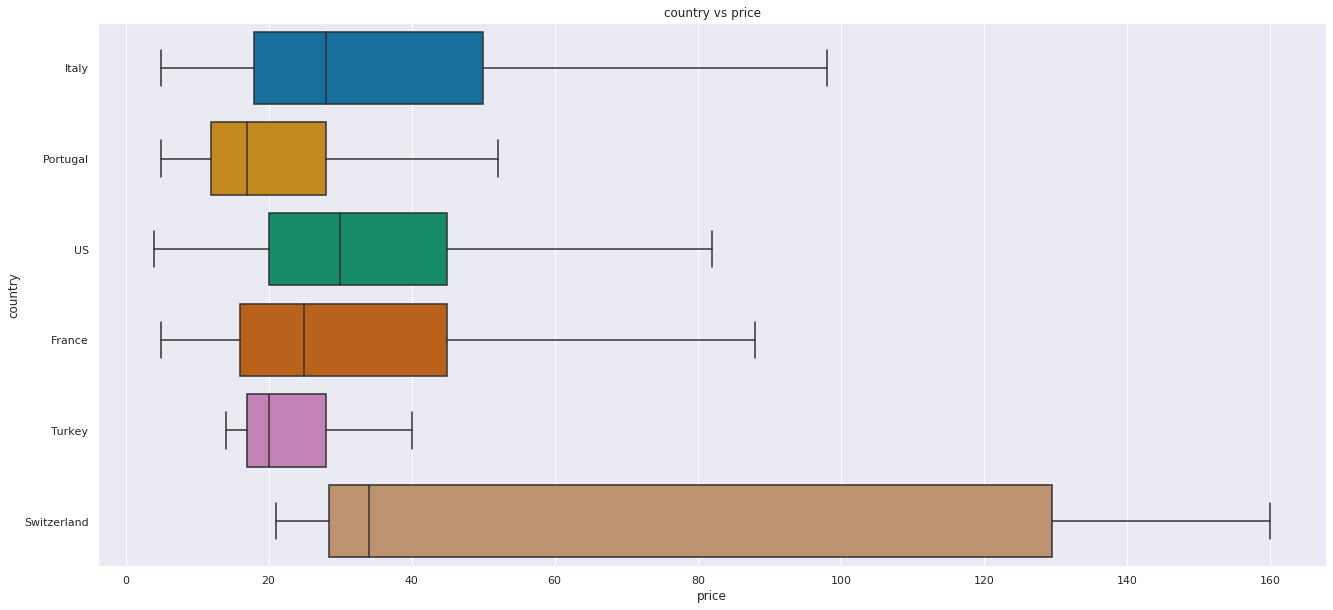

In [41]:
#Interquartile range of the inspection score versus risk category
sns_plot = sns.boxplot( y=boxplot_df['country'], x=boxplot_df['price'], palette='colorblind', showfliers=False);
plt.title('country vs price')
plt.show()
fig = sns_plot.get_figure()
fig.savefig("country_vs_price.png")

# I wanted to show switzerland and how there are no outliers although there is a nice amount os samples. Interesting? I think so.
# For missing prices I am planning to use the switzerland prices. I think that should create a proper impute along with being random.

# I removed the outliers when constructing the chart simply because of readability but switzerland seems like
# th emost uniform pricing. 


### Initially I was saying, figures...Switzerland has the oldest policy of military neutrality in the world; it has not participated in a foreign war since its neutrality was established by the Treaty of Paris in 1815. It certainly carried over to wine prices. Hilarious!!!

In [42]:
# I should have done this before, I wonder how many countries have how many reviews / wines.
# Wait a minute Now i see Switzerland has only 6 reviews, this explains the uniformity!!!
from collections import Counter
print(Counter(df['country']))

Counter({'US': 50457, 'France': 20353, 'Italy': 17940, 'Spain': 6116, 'Portugal': 5256, 'Chile': 4184, 'Argentina': 3544, 'Austria': 3034, 'Australia': 2197, 'Germany': 1992, 'South Africa': 1301, 'New Zealand': 1278, 'Israel': 466, 'Greece': 432, 'Canada': 226, 'Bulgaria': 132, 'Hungary': 129, 'Romania': 102, 'Uruguay': 98, 'Turkey': 81, 'Slovenia': 77, 'Georgia': 76, 'Croatia': 70, 'Mexico': 68, 'England': 63, 'Unknown': 59, 'Moldova': 56, 'Brazil': 49, 'Lebanon': 32, 'Morocco': 24, 'Peru': 16, 'Ukraine': 14, 'Czech Republic': 11, 'Macedonia': 11, 'Cyprus': 10, 'Serbia': 8, 'India': 8, 'Switzerland': 6, 'Luxembourg': 5, 'Armenia': 2, 'Bosnia and Herzegovina': 2, 'Slovakia': 1, 'China': 1, 'Egypt': 1})


In [43]:
df.head(3)
# update region_1 to region. 

,id,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [44]:
# Check missing data, again
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

missing_data  = pd.concat([total, percent], axis=1, keys=['Total Number', 'Percent of Total'])
missing_data.style.applymap(color_negative_red)

,Total Number,Percent of Total
designation,34545,28.790379
region_1,19560,16.301630
price,8395,6.996533
province,59,0.049172
winery,0,0.000000
variety,0,0.000000
title,0,0.000000
taster_name,0,0.000000
points,0,0.000000
description,0,0.000000


In [45]:
df=df.rename(columns={"region_1": "region"})
df.head(3)

# Time to rename the column name.

,id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [46]:
df['province'].fillna('Unknown', inplace=True)
df['region'].fillna(df['province'], inplace=True)
df['designation'].fillna(df['region'], inplace=True)

# After thinking about this for a long time, I think this way gets the minimum number of values get the unknown. 
# The Idea of using unknown is to keep the relation between them. Plus I dont think it matters for my ultimate goal

In [47]:
# Check missing data, again
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)

missing_data  = pd.concat([total, percent], axis=1, keys=['Total Number', 'Percent of Total'])
missing_data.style.applymap(color_negative_red)

# And finally there was the price!!! This is quite important. Earlier I categorized median price per country
# It has to be median, I could also populate everything with prices from Switzerland too.
# But one other way would be to impute the prices? - KNN Imputer

,Total Number,Percent of Total
price,8395,6.996533
winery,0,0.000000
variety,0,0.000000
title,0,0.000000
taster_name,0,0.000000
region,0,0.000000
province,0,0.000000
points,0,0.000000
designation,0,0.000000
description,0,0.000000


In [48]:
# I can do a quick impute by taking the median of each country wine's price
# and the populating the missing prices. 
frames = []
for i in list(set(df['country'])):
    df_country = df[df['country']== i]
    df_country['price'].fillna(df_country['price'].median(),inplace = True)
    frames.append(df_country)
    df_clean = pd.concat(frames)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
print(df_clean.isnull().sum()) 

id             0
country        0
description    0
designation    0
points         0
price          1
province       0
region         0
taster_name    0
title          0
variety        0
winery         0
dtype: int64


In [50]:
df_clean.dropna(inplace=True)

In [51]:
df_clean["vintage"] = df_clean["title"].str.extract("(\d*\.?\d+)", expand=True)
df_clean.head()

,id,country,description,designation,points,price,province,region,taster_name,title,variety,winery,vintage
36,36,Chile,"White flower, lychee and apple aromas carry th...",Estate,86,15.0,Colchagua Valley,Colchagua Valley,Michael Schachner,Estampa 2011 Estate Viognier-Chardonnay (Colch...,Viognier-Chardonnay,Estampa,2011
44,44,Chile,A berry aroma comes with cola and herb notes. ...,Maule Valley,86,9.0,Maule Valley,Maule Valley,Michael Schachner,Sundance 2011 Merlot (Maule Valley),Merlot,Sundance,2011
51,51,Chile,This is much different than Casa Silva's 2009 ...,Gran Reserva,85,22.0,Colchagua Valley,Colchagua Valley,Michael Schachner,Casa Silva 2008 Gran Reserva Petit Verdot (Col...,Petit Verdot,Casa Silva,2008
58,58,Chile,Lightly herbal strawberry and raspberry aromas...,Reserve,85,13.0,Maipo Valley,Maipo Valley,Michael Schachner,Tres Palacios 2011 Reserve Pinot Noir (Maipo V...,Pinot Noir,Tres Palacios,2011
80,80,Chile,Caramelized oak and vanilla aromas are front a...,Special Release Reserva,86,12.0,Rapel Valley,Rapel Valley,Michael Schachner,Aresti 2014 Special Release Reserva Carmenère ...,Carmenère,Aresti,2014


### it looks like if I extract year from title I can reconstruct it using winery name. looks like winery name + year + variety + region + province + designation. meaning I can extract just the year and that can be a better feature on its own then the title altogether since most of the title's contents are available in other fields. I also learned year of production for wine is called vintage. 

## Create and Pickle multiple datasets

### Why Pickle? After all I have been using to_csv nicely. This sentence changed my mind about pickling. But also I happen do love pickles and understand the analogy:"Python-pickling does the same thing for Python objects. It creates a serialized, byte-wise .pkl file that preserves a Python object precisely and exactly." (ref- https://medium.com/better-programming/dont-fear-the-pickle-using-pickle-dump-and-pickle-load-5212f23dbbce)  

### Initially I thought I need multiple data sets. One with entire df and the second one only with description and variety and then a final one as a corpus single text. Then when I was revisiting the project I realized if something changes, I will have to rerun all al this stage again, however if I keep it as a single pickled data set then things should translate easier. For these reasons i will only create one.

In [52]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/MSDS696'

In [53]:
import pickle

In [54]:
with open('/home/ec2-user/SageMaker/MSDS696/wine_msds.pkl', 'wb') as f:
    pickle.dump(df_clean, f)

#### Test if it works

In [55]:
with open('/home/ec2-user/SageMaker/MSDS696/wine_msds.pkl', 'rb') as f:
    wine_msds = pickle.load(f)

In [56]:
wine_msds.shape

(119987, 13)